In [1]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    df = engine.calculateDailyResult()
    return df

In [2]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'fengxiu'
    
    # 策略参数
    fastPeriod = 20; slowPeriod = 40
    signalMaPeriod = 20
    stopRatio = 0.04
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod',
                 'slowPeriod',
                 'signalMaPeriod',
                 'stopRatio'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return

        signalMa = ta.EMA(am15.close, self.signalMaPeriod)

        maUp = signalMa[-1]>signalMa[-3] # 均线上涨
        maDn = signalMa[-1]<signalMa[-3] # 均线下跌
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if maUp and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if maDn and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推MultiFrameMaDf = runBacktesting(MultiFrameMaStrategy, {'symbolList':['BTCUSDT:binance']} , '20180901 12:00', \
                            '20181126 12:00', 0.002, 5/10000)送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x00000259D455CD08>, <__main__.MultiFrameMaStrategy object at 0x00000259D4531AC8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x00000259D455CBF8>, <__main__.MultiFrameMaStrategy object at 0x00000259D4531AC8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x00000259D455CC80>, <__main__.MultiFrameMaStrategy object at 0x00000259D4531AC8>)
2018-12-06 19:04:45.991108	开始回测
2018-12-06 19:04:45.991108	策略初始化
2018-12-06 19:04:45.992190	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-06 19:04:49.773877	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-06 19:04:49.789833	载入完成，数据量：12000
2018-12-06 19:04:49.791833	策略初始化完成
2018-12-06 19:04:49.791833	策略启动完成
2018-12-06 19:04:49.791833	开始回放回测数据,回测范围:[20180901 12:00,20181

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 293, in loadHistoryData
    file_data.to_hdf(file_path, key="d")
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1993, in to_hdf
    return pytables.to_hdf(path_or_buf, key, self, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 278, in to_hdf
    complib=complib) as store:
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 491, in __init__
    self.open(mode=mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 604, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tables\file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "C:\ProgramData\Anacon

2018-12-06 19:05:01.784871	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-06 19:05:01.833741	载入完成，数据量：123210
2018-12-06 19:05:01.851784	当前回放数据:[20180901 12:00,20181126 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-06 19:05:01.854686	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 293, in loadHistoryData
    file_data.to_hdf(file_path, key="d")
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1993, in to_hdf
    return pytables.to_hdf(path_or_buf, key, self, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 278, in to_hdf
    complib=complib) as store:
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 491, in __init__
    self.open(mode=mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 604, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tables\file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "C:\ProgramData\Anacon

2018-12-06 19:05:02.791214	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-06 19:05:02.795170	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-06 19:05:02.841046	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 293, in loadHistoryData
    file_data.to_hdf(file_path, key="d")
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1993, in to_hdf
    return pytables.to_hdf(path_or_buf, key, self, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 278, in to_hdf
    complib=complib) as store:
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 491, in __init__
    self.open(mode=mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 604, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tables\file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "C:\ProgramData\Anacon

2018-12-06 19:05:08.530755	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-06 19:05:08.554659	载入完成，数据量：53630
2018-12-06 19:05:08.572611	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-06 19:05:08.598541	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-06 19:05:08.598541	！！ 数据量为 0 ！！


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 293, in loadHistoryData
    file_data.to_hdf(file_path, key="d")
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1993, in to_hdf
    return pytables.to_hdf(path_or_buf, key, self, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 278, in to_hdf
    complib=complib) as store:
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 491, in __init__
    self.open(mode=mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 604, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tables\file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "C:\ProgramData\Anacon

[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000 , 20180901110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7

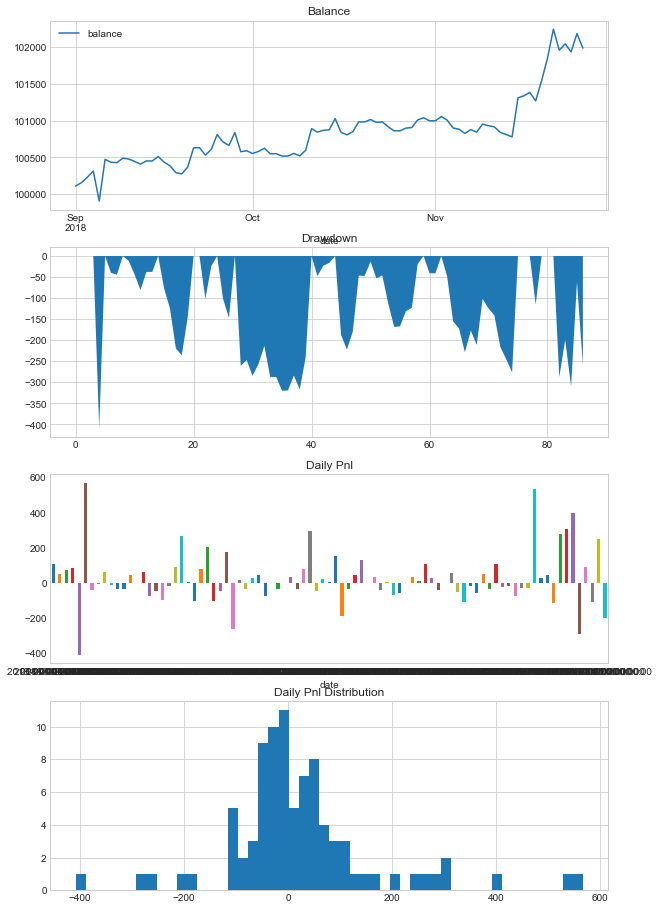

2018-12-06 19:05:30.041745	计算回测结果
2018-12-06 19:05:30.052634	------------------------------
2018-12-06 19:05:30.053632	第一笔交易：	2018-09-04 06:45:00
2018-12-06 19:05:30.053632	最后一笔交易：	2018-11-26 11:58:00
2018-12-06 19:05:30.053632	总交易次数：	70
2018-12-06 19:05:30.053632	总盈亏：	1,985.85
2018-12-06 19:05:30.053632	最大回撤: 	-964.09
2018-12-06 19:05:30.053632	平均每笔盈利：	28.37
2018-12-06 19:05:30.053632	平均每笔滑点：	0.0
2018-12-06 19:05:30.053632	平均每笔佣金：	6.13
2018-12-06 19:05:30.053632	胜率		25.71%
2018-12-06 19:05:30.053632	盈利交易平均值	317.25
2018-12-06 19:05:30.053632	亏损交易平均值	-71.63
2018-12-06 19:05:30.053632	盈亏比：	4.43


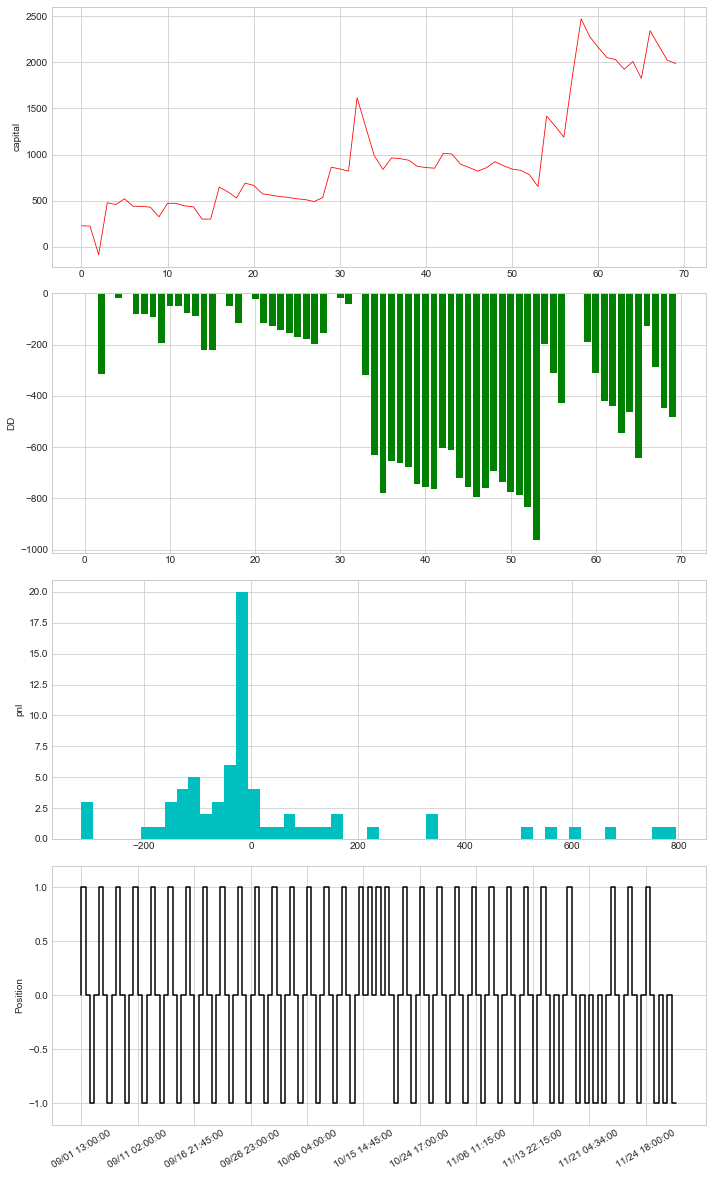

2018-12-06 19:05:31.225499	计算按日统计结果


In [3]:
MultiFrameMaDf = runBacktesting(MultiFrameMaStrategy, {'symbolList':['BTCUSDT:binance']} , '20180901 12:00', \
                            '20181126 12:00', 0.002, 5/10000)

In [4]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class CCITrendStrategy(CtaTemplate):
    className = 'CCITrendStrategy'
    author = 'fengxiu'
    
    # 策略参数
    fastPeriod = 30; slowPeriod = 60
    S_Period = 5
    signalMaPeriod = 20
    stopRatio = 0.03
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod', 'slowPeriod','S_Period',
                 'signalMaPeriod',
                 'stopRatio'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1
        
        #SMA = ta.SMA(am60.close,self.S_Period)
       #price = am60.close
        #if SMA[-2]>price[-2] and SMA[-1]<price[-1]:
            #self.maTrend[symbol] = 1
        #elif SMA[-2]<price[-2] and SMA[-1]>price[-1]:
            #self.maTrend[symbol] = -1
        #else:
            #self.maTrend[symbol] = 0

        cci = ta.CCI(am60.high,am60.low,am60.close, self.signalMaPeriod)

        cciOverbought = (cci[-1]>-100) and (cci[-2]<=-100) # 超买
        cciOversold = (cci[-1]<100) and (cci[-2]>=100) # 超卖
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if cciOversold and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if cciOverbought and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
#                 self.cancelAll() # 撤销挂单
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
#             print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function CCITrendStrategy.on60MinBar at 0x00000259DD2781E0>, <__main__.CCITrendStrategy object at 0x00000259D9623128>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function CCITrendStrategy.onBar at 0x00000259DD278158>, <__main__.CCITrendStrategy object at 0x00000259D9623128>)
2018-12-06 19:05:31.311268	开始回测
2018-12-06 19:05:31.311268	策略初始化
2018-12-06 19:05:31.314260	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-06 19:05:33.267037	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-06 19:05:33.273019	载入完成，数据量：12000
2018-12-06 19:05:33.276011	策略初始化完成
2018-12-06 19:05:33.276011	策略启动完成
2018-12-06 19:05:33.276011	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-06 19:05:33.302940	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 293, in loadHistoryData
    file_data.to_hdf(file_path, key="d")
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1993, in to_hdf
    return pytables.to_hdf(path_or_buf, key, self, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 278, in to_hdf
    complib=complib) as store:
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 491, in __init__
    self.open(mode=mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 604, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tables\file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "C:\ProgramData\Anacon

2018-12-06 19:05:56.114399	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-06 19:05:56.208181	载入完成，数据量：250208
2018-12-06 19:05:56.243058	当前回放数据:[20180601 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-06 19:05:56.245051	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 293, in loadHistoryData
    file_data.to_hdf(file_path, key="d")
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1993, in to_hdf
    return pytables.to_hdf(path_or_buf, key, self, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 278, in to_hdf
    complib=complib) as store:
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 491, in __init__
    self.open(mode=mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 604, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tables\file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "C:\ProgramData\Anacon

2018-12-06 19:05:57.054947	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-06 19:05:57.058873	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-06 19:05:57.101795	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 293, in loadHistoryData
    file_data.to_hdf(file_path, key="d")
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1993, in to_hdf
    return pytables.to_hdf(path_or_buf, key, self, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 278, in to_hdf
    complib=complib) as store:
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 491, in __init__
    self.open(mode=mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 604, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tables\file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "C:\ProgramData\Anacon

2018-12-06 19:06:02.774008	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-06 19:06:02.797586	载入完成，数据量：53630
2018-12-06 19:06:02.818549	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-06 19:06:02.844722	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-06 19:06:02.844722	！！ 数据量为 0 ！！


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 293, in loadHistoryData
    file_data.to_hdf(file_path, key="d")
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1993, in to_hdf
    return pytables.to_hdf(path_or_buf, key, self, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 278, in to_hdf
    complib=complib) as store:
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 491, in __init__
    self.open(mode=mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 604, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tables\file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "C:\ProgramData\Anacon

[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-06 19:06:28.067271	数据回放结束ss: 100%    
2018-12-06 19:06:28.067271	计算按日统计结果
2018-12-06 19:06:28.111152	------------------------------
2018-12-06 19:06:28.112958	首个交易日：	2018-06-01 00:00:00
2018-12-06 19:06:28.112958	最后交易日：	2018-11-23 00:00:00
2018-12-06 19:06:28.112958	总交易日：	176
2018-12-06 19:06:28.112958	盈利交易日	91
2018-12-06 19:06:28

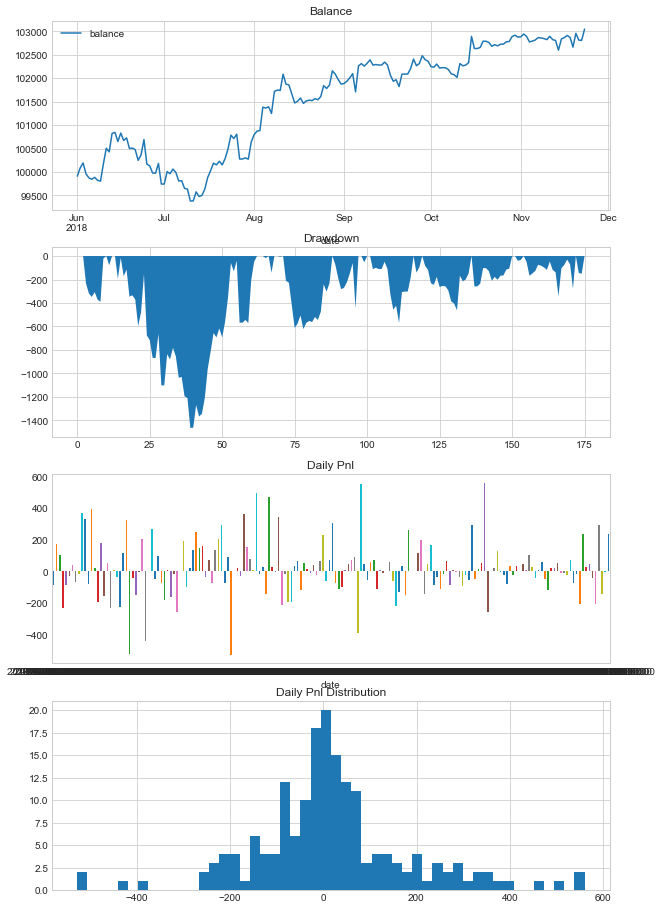

2018-12-06 19:06:32.813574	计算回测结果
2018-12-06 19:06:32.824575	------------------------------
2018-12-06 19:06:32.824575	第一笔交易：	2018-06-05 03:00:00
2018-12-06 19:06:32.825574	最后一笔交易：	2018-11-23 11:58:00
2018-12-06 19:06:32.825574	总交易次数：	59
2018-12-06 19:06:32.825574	总盈亏：	3,046.76
2018-12-06 19:06:32.825574	最大回撤: 	-1,100.87
2018-12-06 19:06:32.825574	平均每笔盈利：	51.64
2018-12-06 19:06:32.825574	平均每笔滑点：	0.0
2018-12-06 19:06:32.825574	平均每笔佣金：	6.55
2018-12-06 19:06:32.825574	胜率		38.98%
2018-12-06 19:06:32.825574	盈利交易平均值	341.0
2018-12-06 19:06:32.825574	亏损交易平均值	-133.23
2018-12-06 19:06:32.825574	盈亏比：	2.56


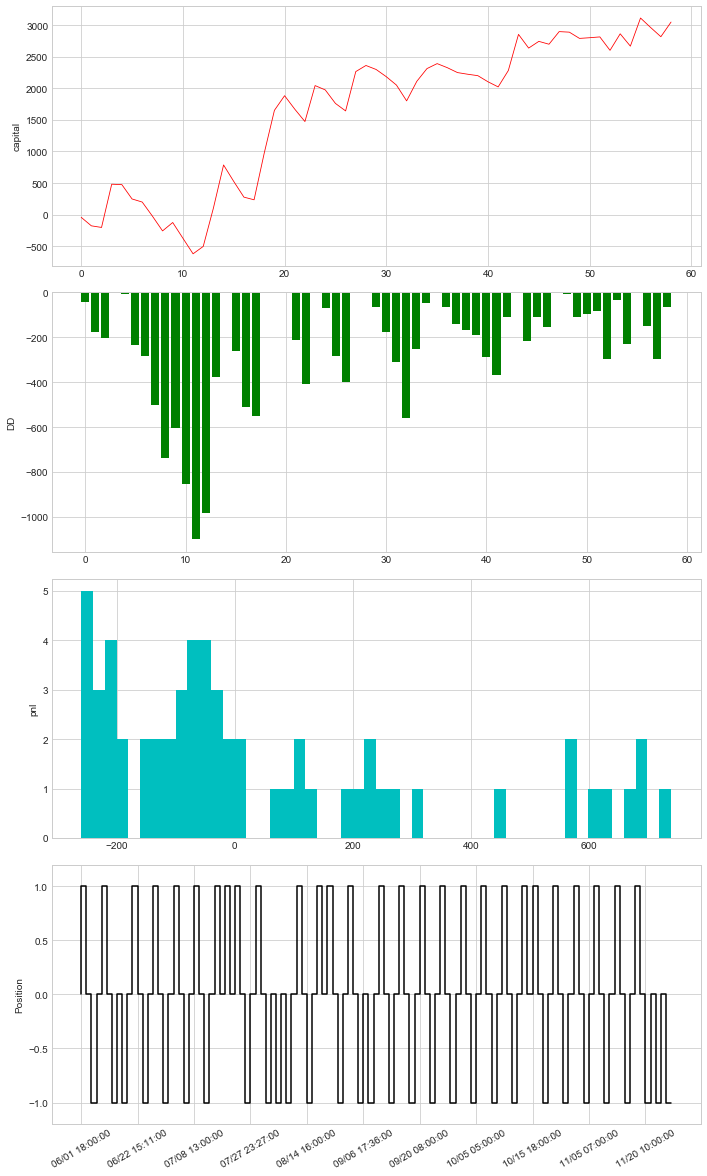

2018-12-06 19:06:34.049267	计算按日统计结果


In [5]:
cciTrendDf = runBacktesting(CCITrendStrategy, {'symbolList':['BTCUSDT:binance']} , '20180601 12:00', \
                            '20181123 12:00', 0.002, 5/10000)

In [6]:
MultiFrameMaDf.tail()

,netPnl,slippage,commission,turnover,tradeCount,tradingPnl,positionPnl,totalPnl
date,,,,,,,,
2018-11-22,-287.53373,0.012,13.96173,27923.46,6,-344.00,70.44,-273.56
2018-11-23,87.90607,0.004,4.52993,9059.86,2,249.88,-157.44,92.44
2018-11-24,-109.95526,0.004,4.44126,8882.52,2,-138.48,32.97,-105.51
2018-11-25,248.45175,0.012,11.93625,23872.50,6,752.42,-492.02,260.40
2018-11-26,-197.69739,0.004,4.06339,8126.78,2,45.24,-238.87,-193.63


In [7]:
cciTrendDf.tail()

,netPnl,slippage,commission,turnover,tradeCount,tradingPnl,positionPnl,totalPnl
date,,,,,,,,
2018-11-19,-206.875770,0.006,8.379770,16759.54,3,-636.42,437.93,-198.49
2018-11-20,293.943615,0.008,9.418385,18836.77,4,303.37,0.00,303.37
2018-11-21,-144.677010,0.004,4.613010,9226.02,2,-140.06,0.00,-140.06
2018-11-22,-5.701505,0.002,2.279505,4559.01,1,-3.42,0.00,-3.42
2018-11-23,239.440000,0.000,0.000000,0.00,0,0.00,239.44,239.44


In [8]:
PortfolioDf = MultiFrameMaDf+cciTrendDf
PortfolioDf = PortfolioDf.dropna()

# 创建回测引擎，并设置组合回测初始资金后，显示结果
engine = BacktestingEngine()
engine.setCapital(1000000)
dfp, result = engine.calculateDailyStatistics(PortfolioDf)
result

{'startDate': Timestamp('2018-09-01 00:00:00'),
 'endDate': Timestamp('2018-11-23 00:00:00'),
 'totalDays': 84,
 'profitDays': 46,
 'lossDays': 36,
 'endBalance': 1003218.53192,
 'maxDrawdown': -796.2372650000034,
 'maxDdPercent': -0.07958108044458041,
 'totalNetPnl': 3218.531919999995,
 'dailyNetPnl': 38.31585619047613,
 'totalCommission': 614.35808,
 'dailyCommission': 7.313786666666666,
 'totalSlippage': 0.39000000000000007,
 'dailySlippage': 0.004642857142857144,
 'totalTurnover': 1228716.1600000001,
 'dailyTurnover': 14627.573333333336,
 'totalTradeCount': 195.0,
 'dailyTradeCount': 2.3214285714285716,
 'totalReturn': 0.32185319199999896,
 'annualizedReturn': 0.9195805485714257,
 'dailyReturn': 0.0036832954712166335,
 'returnStd': 0.0258403607733923,
 'sharpeRatio': 2.2082264476542726}

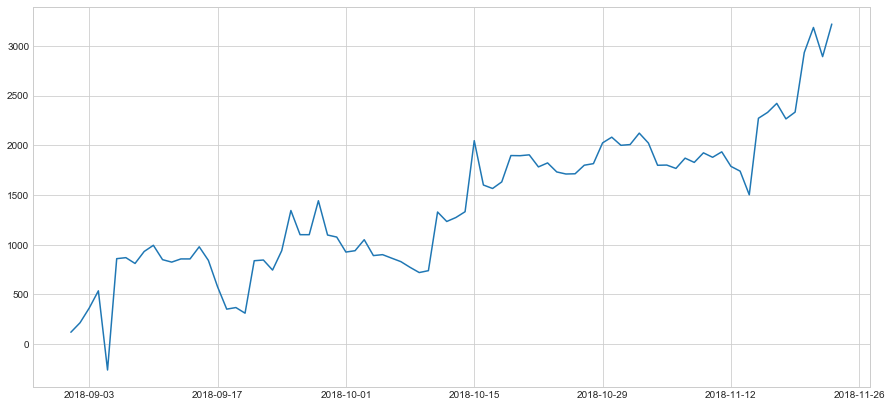

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(PortfolioDf['netPnl'].cumsum())
plt.show()